### Outline
------------------------------------------------------------------------
1) Introdução
2) Metodologia
    - Descrição dos procedimentos
3) Análise Descritiva e Limpeza    
    - Histogramas
    - Normalizacao 
4) Modelagem
    * Redução de dimensionalidade
        - UMAP
    * Clusterização
        - GMM
    * Classificação 
        - glmnet
        - Random Forest
5) Resultados e conclusões
------------------------------------------------------------------------


# 1. Introdução

Uma grande multinacional varejista do ramo de supermercados deseja ingressar no mercado brasileiro. Você é o responsável pela análise que servirá de base para a estratégia (tomada de decisão) de entrada dessa empresa no Brasil.
A escolha do local é uma das decisoes mais importantes que deve-se levar em consideração durante a implementação de uma nova franquia de varejo, pois determina a vantagem completitiva sobre outras franquias.

O objetivo desde notebook é ELABORAR e IMPLEMENTAR os seguintes itens:


 *  **Realizar uma clusterização dos municípios brasileiros com base nas informações disponíveis e fazer uma caracterização dos           municípios em grupos.**
 
 *  **Elaborar uma forma de classificar um novo município entre os grupos já criados na etapa anterior**
 
 * **Responder quais grupos de municípios deveriam ser a porta de entrada para empresa no país e porque.**
 

In [1]:
import os
import pandas as pd
import numpy as np
import scipy

import sklearn as sk
import shap
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

import matplotlib.pyplot as plt
import seaborn

os.getcwd()

'/projects'

# 2. Análise descritiva e limpeza dos dados

Antes de começarmos a modelagem dos dados, devemos selecionar somente as columas numéricas que representam as nossas variáveis onde queremos realizar a clusterização das observações. Como as variáveis estão em diferentes escalas, e iremos utilizar técnicas de redução de dimensionalidade que sao baseados em KNN, é de grande ajuda converter as features em z-scores ou normalizá-las em seu range (minmax)

In [2]:
## leitura do dataset
diretorio = "/projects/data/raw/dados_municipais.csv"
dados_municipais = pd.read_csv(diretorio, sep = ",")

In [3]:
## Selecionando somente as colunas numéricas
columns = [ 
	   'Densidade_demográfica_2000', 'Distância_à_capital_km_',
       'Esperança_de_vida_ao_nascer_2000',
       'Mortalidade_até_um_ano_de_idade_2000',
       'Taxa_de_fecundidade_total_2000',
       'Percentual_de_pessoas_de_25_anos_ou_mais_analfabetas_2000',
       'Renda_per_Capita_2000', 'Índice_de_Gini_2000',
       'Intensidade_da_indigência_2000', 'Intensidade_da_pobreza_2000',
       'Índice_de_Desenvolvimento_Humano_Municipal_2000',
       'Taxa_bruta_de_freqüência_à_escola_2000', 'Taxa_de_alfabetização_2000',
       'Média_de_anos_de_estudo_das_pessoas_de_25_anos_ou_mais_de_idade_2000',
       'População_de_25_anos_ou_mais_de_idade_1991',
       'População_de_25_anos_ou_mais_de_idade_2000',
       'População_de_65_anos_ou_mais_de_idade_1991',
       'População_de_65_anos_ou_mais_de_idade_2000', 'População_total_1991',
       'População_total_2000', 'População_urbana_2000',
       'População_rural_2000'
    ]

dados_municipais_numericFeatures = dados_municipais[columns].values
dados_municipais_numericFeatures.shape

## normalizacao
scale = sk.preprocessing.MinMaxScaler()
minmax = scale.fit_transform(dados_municipais_numericFeatures)
df_std = pd.DataFrame(minmax)
df_std.columns = columns


------------------------------------------

### 2.1 - Análise Exploratória

A seguinte tabela mostra as estatisticas descritivas das variáveis numéricas do dataset.
 

In [4]:
## estatisticas descritivas do dataset
print(df_std.shape)
#dados_municipais.describe().transpose()
df_std.describe().transpose()

(5360, 22)


,count,mean,std,min,25%,50%,75%,max
Densidade_demográfica_2000,5360.0,0.007417,0.040881,0.0,0.000869,0.001824,0.003689,1.0
Distância_à_capital_km_,5360.0,0.171785,0.110823,0.0,0.082624,0.154661,0.242701,1.0
Esperança_de_vida_ao_nascer_2000,5360.0,0.561566,0.203722,0.0,0.426353,0.582459,0.715904,1.0
Mortalidade_até_um_ano_de_idade_2000,5360.0,0.275640,0.177007,0.0,0.128008,0.231374,0.391600,1.0
Taxa_de_fecundidade_total_2000,5360.0,0.209861,0.119769,0.0,0.123596,0.178170,0.268058,1.0
Percentual_de_pessoas_de_25_anos_ou_mais_analfabetas_2000,5360.0,0.361973,0.222020,0.0,0.175996,0.302682,0.554404,1.0
Renda_per_Capita_2000,5360.0,0.153251,0.103588,0.0,0.062606,0.140526,0.220017,1.0
Índice_de_Gini_2000,5360.0,0.437143,0.127735,0.0,0.347826,0.434783,0.521739,1.0
Intensidade_da_indigência_2000,5360.0,0.563686,0.119236,0.0,0.485056,0.560512,0.639052,1.0
Intensidade_da_pobreza_2000,5360.0,0.466455,0.159645,0.0,0.333841,0.454289,0.590159,1.0


#### Visualizando a distribuição das variáveis:

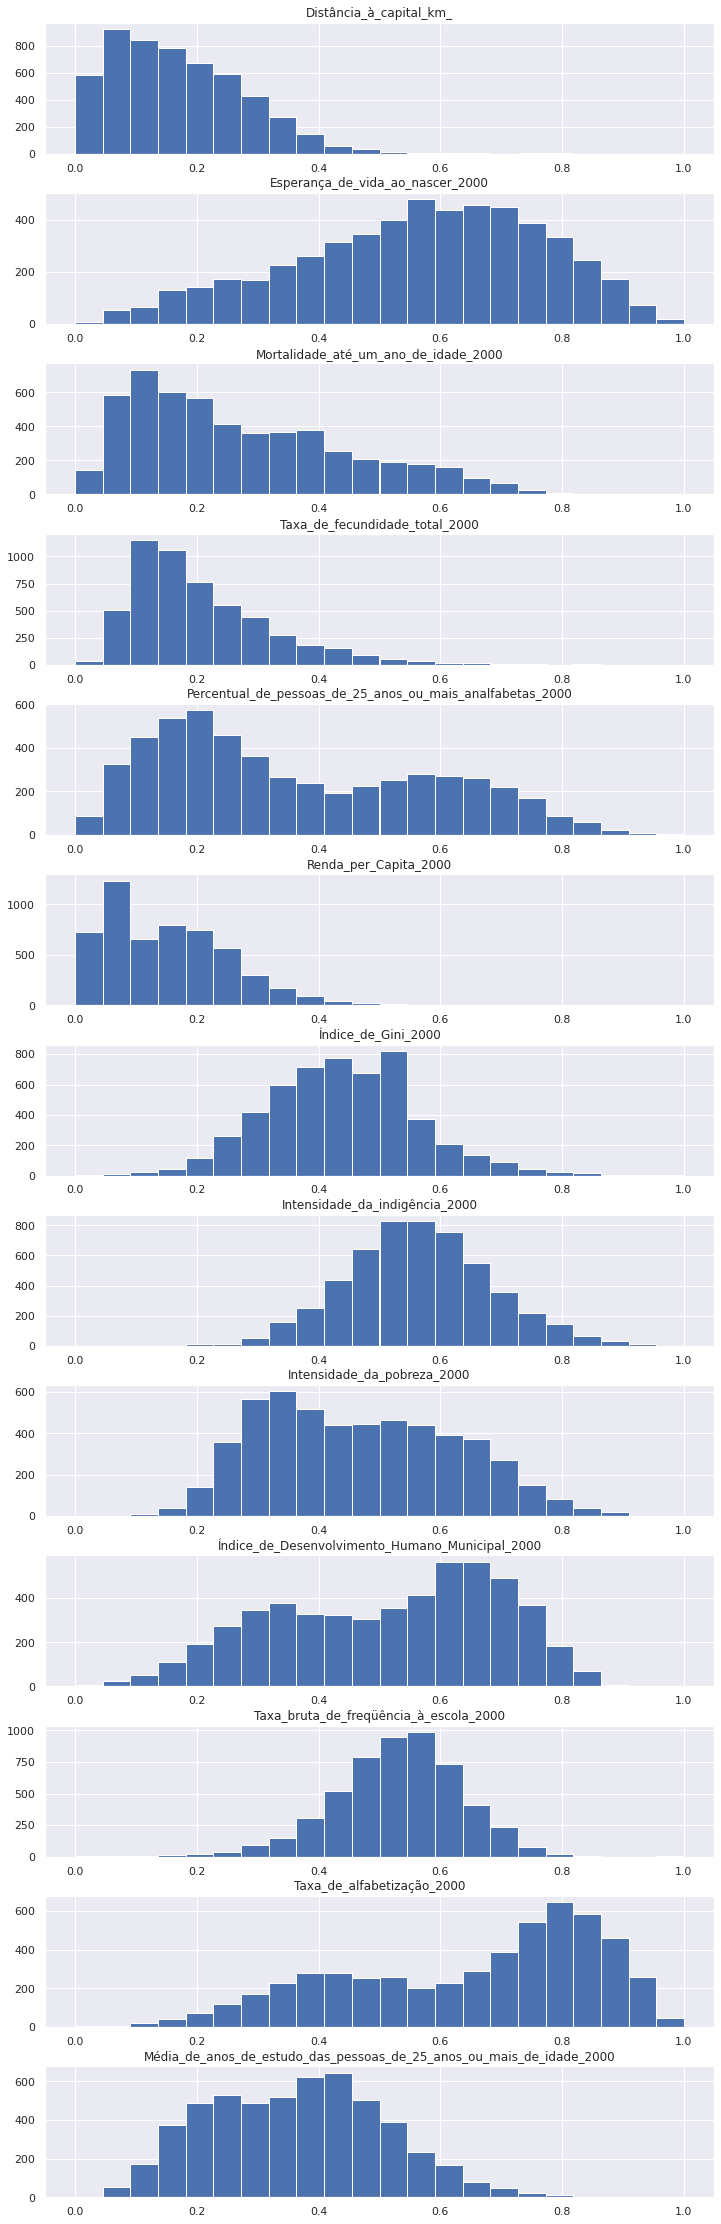

In [249]:
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
seaborn.set(style = "darkgrid")
fig, axes = plt.subplots(7,2, figsize = (12,40))
for i, j in zip(df_std.columns[1:15], range(0, 13)):
    df_std.hist("{0}".format(i), bins = 22 , ax = axes[j])

In [ ]:
#Inserir aqui o motivo da escolha das variaveis 1:14


In [247]:
features_treino = df_std.columns[1:14]
df_treino = df_std[features_treino]

----------------------------------

# 3. Modelagem

## 3.1 - Redução de dimensionalidade

No âmbido do big data, métodos de redução de dimensionalidade são ubíquos. Essas técnicas nos permitem visualizar e sumarizar os dados em espaços topológicos com dimensão inferior àquelas dos dados originais

### UMAP


UMAP é um acrônimo para **Uniform Manifold Aproximation and Projection**. UMAP é utilizado como uma técnica de redução de dimensionalidade. Assim, quando temos um conjunto de dados com um número de variáveis elevado (k > 3), utiliza-se UMAP para projetar essas variáveis num espaço topológico de menor dimensão onde a estrutura original dos dados é preservada.


In [ ]:
#fig, axes =  plt.subplots(9, figsize = (15, 100))
for i, j in zip(itertools.product([25, 50, 100, 200, 300, 400, 500, 600], [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), range(48)):
    redim = UMAP(n_neighbors = i[0], min_dist = i[1], n_components = 5)
    emb = redim.fit_transform(minmax)
    plt.scatter(emb[:,2], emb[:,4])

Após uma busca intensiva no espaço hiperparamétrico, os melhores valores para os hiperparâmetros do UMAP são:

 - n_neighbors = 25
 - min_dist = 0.1 
 - n_components = 2


In [7]:
umap = UMAP(n_neighbors = 25,  min_dist = 0.1, n_components = 2, metric = 'correlation')
UMAP_embedding = umap.fit_transform(df_treino)
embedding = pd.DataFrame(UMAP_embedding)
embedding.columns = ["emb0","emb1"]
#chebyshev performs better than mahalanobis
#correlation metric has performed better than chebyshev

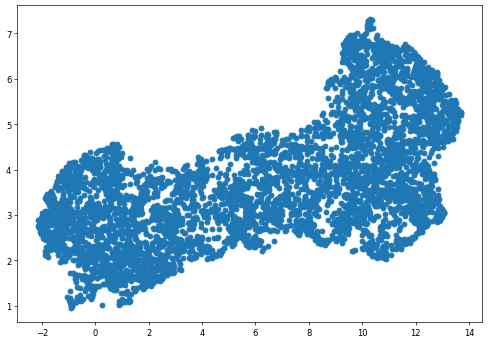

In [8]:
plt.figure(figsize=(10, 7), dpi=60)
plt.scatter(UMAP_embedding[:,0], UMAP_embedding[:,1])

## 3.2. Clusterização

O Mapa de calor a seguir mostra os pontos de maior densidade, indicando os possíveis clusters.
Devido à anisotropia presente na projeção dos dados obtidos pelo processo de redução de dimensionalidade e nas multiplas vizinhanças onde a densidade da distribuição é elevada, temos indícios de que um modelo gaussiano misto (GMM) possa ser adequado para realizar a clusterizacao dos municipios


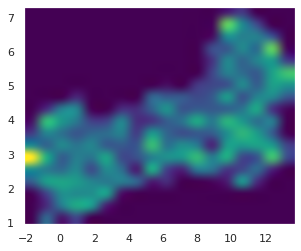

<Figure size 432x288 with 0 Axes>

In [252]:
heatmap, xedges, yedges = np.histogram2d(embedding['emb0'], embedding['emb1'], bins=18)

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.grid(False)
plt.imshow(heatmap.T, extent=extent, origin='lower',cmap="viridis",aspect=2, interpolation="catrom",interpolation_stage="rgba")
plt.show()
plt.clf()

### 3.2.1. - GMM 

Gaussian Mixture Models ou Modelo de Misturas Gaussianas é um modelo probabilístico paramétrico onde ajustamos uma combinação linear convexa de componentes probabilisticas com distribuição normal.
Um GMM com K componentes é dado pela expressão:

$$f(x) = \sum_{i=1}^K \pi_i N(\pmb{x}| \pmb{\mu}_i, \Sigma_i)$$

Em que  \
$\mu_i$: vetor de médias da i-ésima componente \
$\Sigma_i$: matriz de variância-covariância da i-ésima componente \
$ 0 \leq \pi_i \leq 1;   \sum_{i=1}^K \pi_i = 1$

No GMM é necessário estimar $3K$ parâmetros:

$$(\pi_1 \ldots \pi_K,\mu_K, \ldots, \mu_K, \Sigma_1, \ldots, \Sigma_K)$$

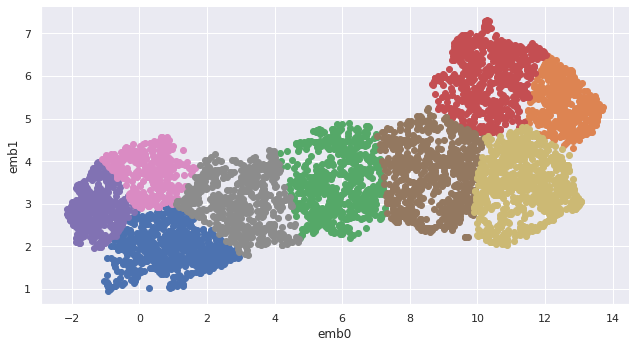

In [316]:
np.random.seed(561)
#np.random.seed(6114)
gmm = GaussianMixture(n_components = 9, init_params = "kmeans", max_iter = 100, covariance_type = 'diag' )

gmm = gmm.fit(embedding)

mixtures = pd.DataFrame({"model" : gmm.predict(embedding)})

df_c = pd.concat([embedding,  mixtures.reset_index(drop = True)], axis = 1)

df_c.columns = ['emb0','emb1',"model"]

#plotting clusters
fg = seaborn.FacetGrid(data=df_c, hue='model', aspect=1.8,height =5)
fg.map(plt.scatter, 'emb0',"emb1")

In [317]:
dados_clusterizados = pd.DataFrame(df_std)
dados_clusterizados.columns = columns
dados_clusterizados = pd.concat([dados_clusterizados, mixtures.reset_index(drop = True)], axis = 1)
print("Quantidade de observações por cluster:")
dados_clusterizados.groupby(['model'])['model'].count()

Quantidade de observações por cluster:


model
0    651
1    467
2    677
3    661
4    403
5    739
6    377
7    567
8    818
Name: model, dtype: int64

### Definindo a quantidade ideal de componentes

In [294]:
np.random.seed(151561)

S = []

BIC = []

K = range(2,30)

X = df_c[['emb0', 'emb1']]

for k in K:
    model = GaussianMixture(n_components = k, init_params = "kmeans", max_iter = 100, covariance_type = 'diag' )

    labels = model.fit_predict(X)
    
    S.append(sk.metrics.silhouette_score(X, labels, metric = 'euclidean'))
    
    BIC.append(model.bic(X))

Text(0, 0.5, 'BIC')

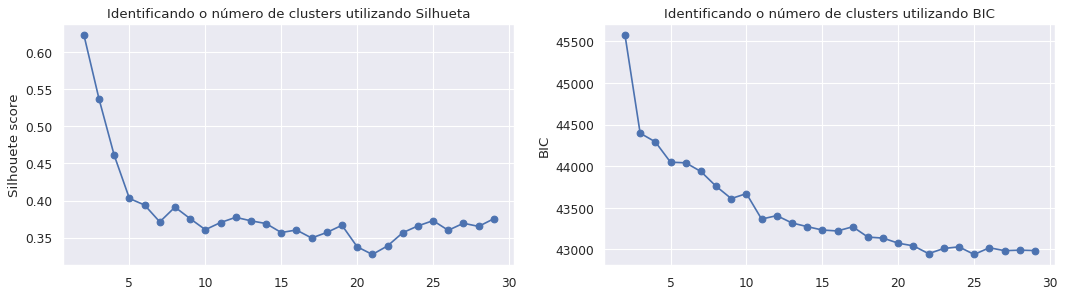

In [295]:
fig, (sub,sub1) = plt.subplots(1,2, figsize = (16,4),dpi=80)
sub.plot(K, S, 'bo-')
sub.set_ylabel("Silhouete score")
sub.set_title("Identificando o número de clusters utilizando Silhueta")
sub1.plot(K, BIC, 'bo-')
sub1.set_title("Identificando o número de clusters utilizando BIC")
sub1.set_ylabel('BIC')

# EAD nos clusters

Nesta sessão iremos analisar os clusters obtidos por meio do GMM para extrair o maximo de informações e caracterizá-los.

In [161]:
1+3.3*np.log(1512)

25.159922237240277

<AxesSubplot:title={'center':'Histograma para a variável: Intensidade_da_pobreza_2000 (cluster 0) '}>

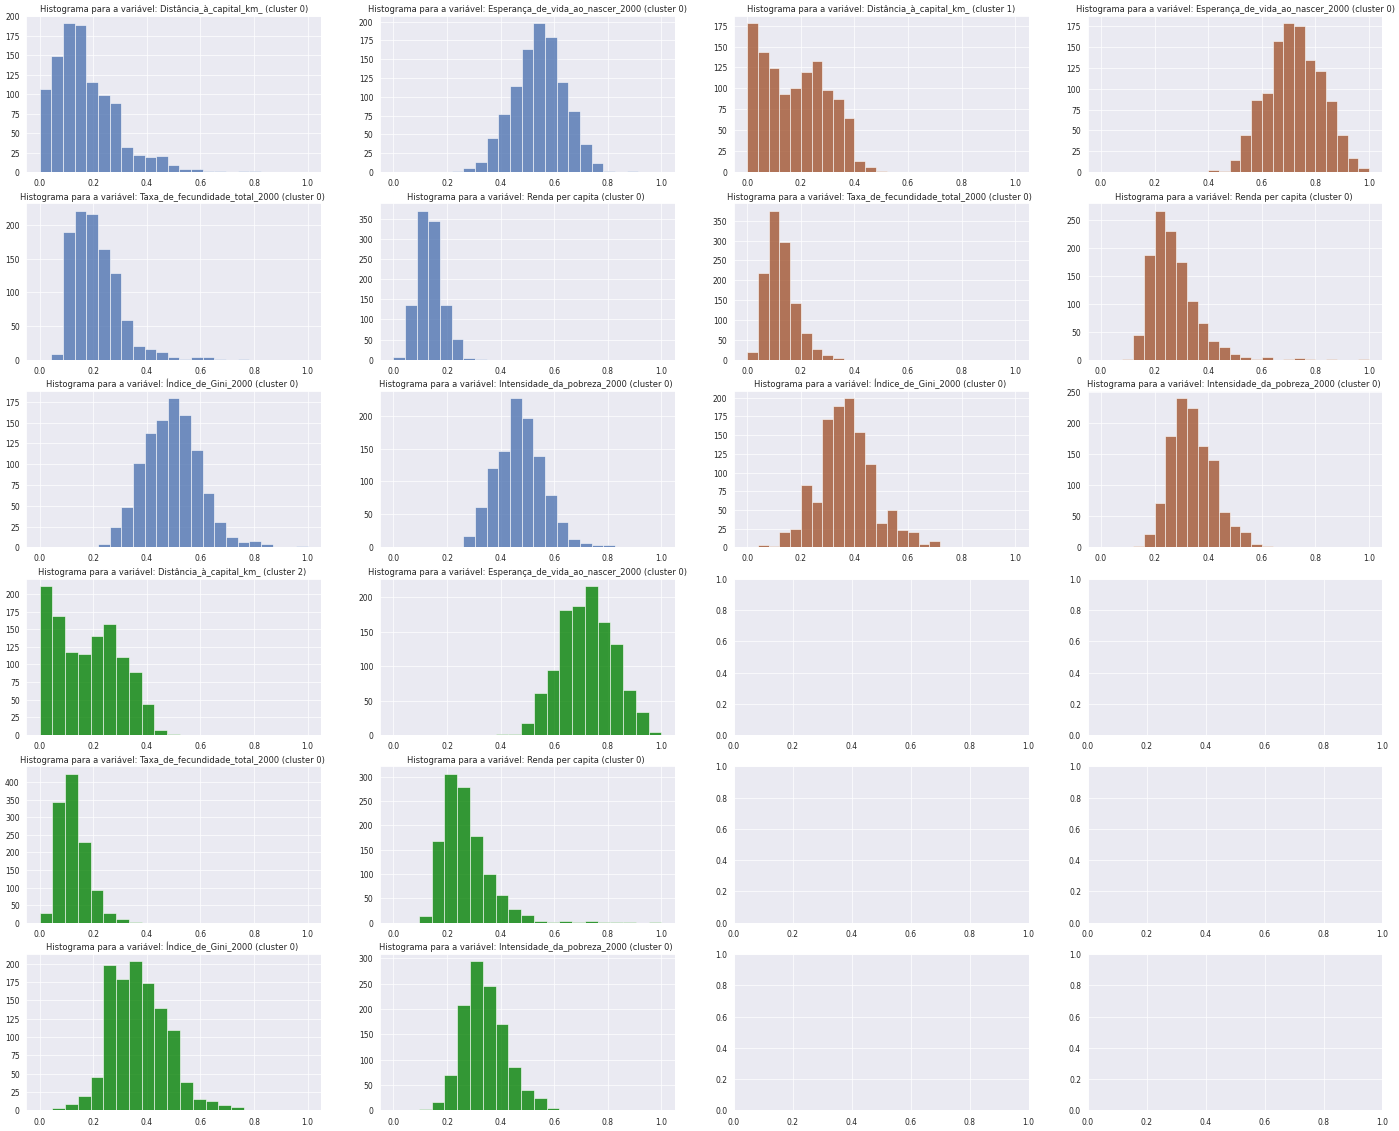

In [257]:
fig, (linha_1 , linha_2, linha_3,linha_4,linha_5,linha_6) = plt.subplots(6,4, figsize = (35,29), dpi = 50)

##cluster 0 
linha_1[0].set_title("Histograma para a variável: Distância_à_capital_km_ (cluster 0)")
dados_clusterizados[dados_clusterizados['model'] == 0]["Distância_à_capital_km_"] \
    .hist(ax = linha_1[0], bins = 23, alpha = 0.78, color = 'b',range=[0, 1])

linha_1[1].set_title("Histograma para a variável: Esperança_de_vida_ao_nascer_2000 (cluster 0)")
dados_clusterizados[dados_clusterizados['model'] == 0]["Esperança_de_vida_ao_nascer_2000"] \
    .hist(ax = linha_1[1], bins = 23, alpha = 0.78, color = 'b',range=[0, 1])

linha_2[0].set_title("Histograma para a variável: Taxa_de_fecundidade_total_2000 (cluster 0) ")
dados_clusterizados[dados_clusterizados['model'] == 0]["Taxa_de_fecundidade_total_2000"] \
    .hist(ax = linha_2[0], bins = 23, alpha = 0.78, color = 'b',range=[0, 1])

linha_2[1].set_title("Histograma para a variável: Renda per capita (cluster 0) ")
dados_clusterizados[dados_clusterizados['model'] == 0]["Renda_per_Capita_2000"] \
    .hist(ax = linha_2[1], bins = 23, alpha = 0.78, color = 'b',range=[0, 1])

linha_3[0].set_title("Histograma para a variável: Índice_de_Gini_2000 (cluster 0) ")
dados_clusterizados[dados_clusterizados['model'] == 0]["Índice_de_Gini_2000"] \
    .hist(ax = linha_3[0], bins = 23, alpha = 0.78, color = 'b',range=[0, 1])


linha_3[1].set_title("Histograma para a variável: Intensidade_da_pobreza_2000 (cluster 0) ")
dados_clusterizados[dados_clusterizados['model'] == 0]["Intensidade_da_pobreza_2000"] \
    .hist(ax = linha_3[1], bins = 23, alpha = 0.78, color = 'b',range=[0, 1])

##cluster 1
linha_1[2].set_title("Histograma para a variável: Distância_à_capital_km_ (cluster 1)")
dados_clusterizados[dados_clusterizados['model'] == 1]["Distância_à_capital_km_"] \
    .hist(ax = linha_1[2], bins = 25, alpha = 0.78, color = 'sienna',range=[0, 1])

linha_1[3].set_title("Histograma para a variável: Esperança_de_vida_ao_nascer_2000 (cluster 0)")
dados_clusterizados[dados_clusterizados['model'] == 1]["Esperança_de_vida_ao_nascer_2000"] \
    .hist(ax = linha_1[3], bins = 25, alpha = 0.78, color = 'sienna',range=[0, 1])

linha_2[2].set_title("Histograma para a variável: Taxa_de_fecundidade_total_2000 (cluster 0) ")
dados_clusterizados[dados_clusterizados['model'] == 1]["Taxa_de_fecundidade_total_2000"] \
    .hist(ax = linha_2[2], bins = 25, alpha = 0.78, color = 'sienna',range=[0, 1])

linha_2[3].set_title("Histograma para a variável: Renda per capita (cluster 0) ")
dados_clusterizados[dados_clusterizados['model'] == 1]["Renda_per_Capita_2000"] \
    .hist(ax = linha_2[3], bins = 25, alpha = 0.78, color = 'sienna',range=[0, 1])

linha_3[2].set_title("Histograma para a variável: Índice_de_Gini_2000 (cluster 0) ")
dados_clusterizados[dados_clusterizados['model'] == 1]["Índice_de_Gini_2000"] \
    .hist(ax = linha_3[2], bins = 25, alpha = 0.78, color = 'sienna',range=[0, 1])


linha_3[3].set_title("Histograma para a variável: Intensidade_da_pobreza_2000 (cluster 0) ")
dados_clusterizados[dados_clusterizados['model'] == 1]["Intensidade_da_pobreza_2000"] \
    .hist(ax = linha_3[3], bins = 25, alpha = 0.78, color = 'sienna',range=[0, 1])

#cluster 2
linha_4[0].set_title("Histograma para a variável: Distância_à_capital_km_ (cluster 2) ")
dados_clusterizados[dados_clusterizados['model'] == 1]["Distância_à_capital_km_"] \
    .hist(ax = linha_4[0], bins = 21, alpha = 0.78, color = 'green',range=[0, 1])


linha_4[1].set_title("Histograma para a variável: Esperança_de_vida_ao_nascer_2000 (cluster 0)")
dados_clusterizados[dados_clusterizados['model'] == 1]["Esperança_de_vida_ao_nascer_2000"] \
    .hist(ax = linha_4[1], bins = 21, alpha = 0.78, color = 'green',range=[0, 1])

linha_5[0].set_title("Histograma para a variável: Taxa_de_fecundidade_total_2000 (cluster 0) ")
dados_clusterizados[dados_clusterizados['model'] == 1]["Taxa_de_fecundidade_total_2000"] \
    .hist(ax = linha_5[0], bins = 21, alpha = 0.78, color = 'green',range=[0, 1])

linha_5[1].set_title("Histograma para a variável: Renda per capita (cluster 0) ")
dados_clusterizados[dados_clusterizados['model'] == 1]["Renda_per_Capita_2000"] \
    .hist(ax = linha_5[1], bins = 21, alpha = 0.78, color = 'green',range=[0, 1])

linha_6[0].set_title("Histograma para a variável: Índice_de_Gini_2000 (cluster 0) ")
dados_clusterizados[dados_clusterizados['model'] == 1]["Índice_de_Gini_2000"] \
    .hist(ax = linha_6[0], bins = 21, alpha = 0.78, color = 'green',range=[0, 1])


linha_6[1].set_title("Histograma para a variável: Intensidade_da_pobreza_2000 (cluster 0) ")
dados_clusterizados[dados_clusterizados['model'] == 1]["Intensidade_da_pobreza_2000"] \
    .hist(ax = linha_6[1], bins = 21, alpha = 0.78, color = 'green',range=[0, 1])


Text(0.5, 1.0, 'Mortalidade_até_um_ano_de_idade_2000')

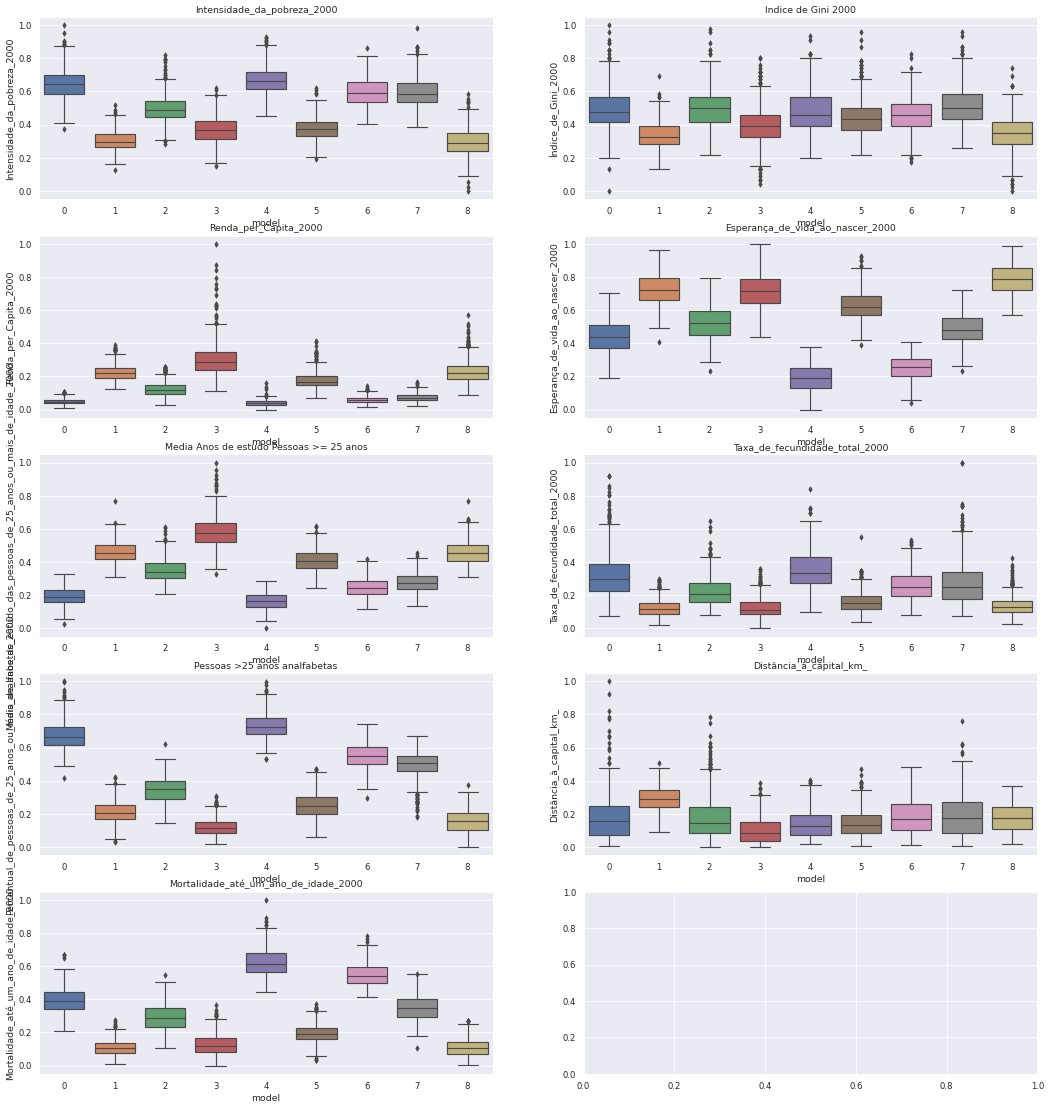

In [318]:
fig, (linha_b_1 , linha_b_2, linha_b_3,linha_b_4,linha_b_5) = plt.subplots(5,2, figsize = (23,25), dpi = 56)
seaborn.boxplot(ax= linha_b_1[0], x = "model", y = "Intensidade_da_pobreza_2000", data = dados_clusterizados,)
linha_b_1[0].set_title('Intensidade_da_pobreza_2000')

seaborn.boxplot(ax= linha_b_1[1], x = "model", y = "Índice_de_Gini_2000", data = dados_clusterizados )
linha_b_1[1].set_title('Indice de Gini 2000')

seaborn.boxplot(ax= linha_b_2[0], x = "model", y = "Renda_per_Capita_2000", data = dados_clusterizados )
linha_b_2[0].set_title('Renda_per_Capita_2000')

seaborn.boxplot(ax= linha_b_2[1], x = "model", y = "Esperança_de_vida_ao_nascer_2000", data = dados_clusterizados )
linha_b_2[1].set_title('Esperança_de_vida_ao_nascer_2000')

seaborn.boxplot(ax= linha_b_3[0], x = "model", y = "Média_de_anos_de_estudo_das_pessoas_de_25_anos_ou_mais_de_idade_2000", data =dados_clusterizados, )
linha_b_3[0].set_title('Media Anos de estudo Pessoas >= 25 anos')

seaborn.boxplot(ax= linha_b_3[1], x = "model", y = "Taxa_de_fecundidade_total_2000", data = dados_clusterizados)
linha_b_3[1].set_title('Taxa_de_fecundidade_total_2000')

seaborn.boxplot(ax= linha_b_4[0], x = "model", y = "Percentual_de_pessoas_de_25_anos_ou_mais_analfabetas_2000", data = dados_clusterizados )
linha_b_4[0].set_title('Pessoas >25 anos analfabetas')

seaborn.boxplot(ax= linha_b_4[1], x = "model", y = "Distância_à_capital_km_", data = dados_clusterizados )
linha_b_4[1].set_title('Distância_à_capital_km_')

seaborn.boxplot(ax= linha_b_5[0], x = "model", y = "Mortalidade_até_um_ano_de_idade_2000", data = dados_clusterizados )
linha_b_5[0].set_title('Mortalidade_até_um_ano_de_idade_2000')


#seaborn.boxplot(x = "model", y= "Intensidade_da_pobreza_2000", data =dados_clusterizados )

Os municípios dos clusters 1, 2 e 3 possuem elevados índices de pobreza e desigualdade com índices de renda per capita muito baixos

O cluster 3 possui maior índice de mortalidade até um ano de idade, os maiores indices de municipios com pessoas com mais de 25 anos analfabetas, o que pode indicar falta de saneamento básico e infra-estrutura em geral.
Esse cluster também abriga os municípios mais distantes até a capital, embora a distribuição das distâncias entre os clusters nao difira muito, esse cluster possui outliers.
Essas condições implicam em uma menor expectativa de vida em relação aos demais clusters.

enquanto que os municipios dos clusters 1 e 4 são mais moderados em relação ao indice de pobreza.

Assim, o cluster 3 é composto por municípios com as seguintes características:
- Altas taxas de fecundidade
- Altos índices de mortalidade infantil
- Elevada quantidade de adultos analfabetos
- Indice de gini mais proximo de zero $q_{0.5}  = 0.347826$ e $q_{0.75}  = 0.391304$ (Valores padronizados ) 
- distribuição do indice de Gini aproximadamente simétrica


In [246]:
dados_clusterizados[dados_clusterizados['model'] == 0].describe()

,Densidade_demográfica_2000,Distância_à_capital_km_,Esperança_de_vida_ao_nascer_2000,Mortalidade_até_um_ano_de_idade_2000,Taxa_de_fecundidade_total_2000,Percentual_de_pessoas_de_25_anos_ou_mais_analfabetas_2000,Renda_per_Capita_2000,Índice_de_Gini_2000,Intensidade_da_indigência_2000,Intensidade_da_pobreza_2000,...,Média_de_anos_de_estudo_das_pessoas_de_25_anos_ou_mais_de_idade_2000,População_de_25_anos_ou_mais_de_idade_1991,População_de_25_anos_ou_mais_de_idade_2000,População_de_65_anos_ou_mais_de_idade_1991,População_de_65_anos_ou_mais_de_idade_2000,População_total_1991,População_total_2000,População_urbana_2000,População_rural_2000,model
count,1109.000000,1109.000000,1109.000000,1109.000000,1109.000000,1109.000000,1109.000000,1109.000000,1109.000000,1109.000000,...,1109.000000,1109.000000,1109.000000,1109.000000,1109.000000,1109.000000,1109.000000,1109.000000,1109.000000,1109.0
mean,0.003074,0.171505,0.538888,0.269464,0.222890,0.326259,0.132549,0.490454,0.560845,0.480670,...,0.362058,0.001329,0.001486,0.001440,0.001489,0.001744,0.001838,0.001416,0.009782,0.0
std,0.011807,0.115428,0.095954,0.079628,0.109558,0.084323,0.046472,0.107181,0.094512,0.097046,...,0.069658,0.002321,0.002724,0.002596,0.002616,0.003054,0.003337,0.003112,0.012007,0.0
min,0.000008,0.002447,0.230382,0.062518,0.072231,0.107708,0.030056,0.217391,0.319710,0.259700,...,0.208145,0.000003,0.000000,0.000002,0.000027,0.000003,0.000016,0.000020,0.000000,0.0
25%,0.000373,0.087424,0.472514,0.207690,0.146067,0.266852,0.096980,0.413043,0.497000,0.409692,...,0.311086,0.000339,0.000339,0.000340,0.000368,0.000433,0.000399,0.000230,0.003222,0.0
50%,0.001048,0.146969,0.545950,0.258318,0.197432,0.323564,0.129304,0.500000,0.553266,0.476290,...,0.357466,0.000673,0.000702,0.000692,0.000726,0.000851,0.000845,0.000498,0.006096,0.0
75%,0.002213,0.234702,0.603021,0.326685,0.271268,0.389654,0.159899,0.565217,0.614853,0.538427,...,0.408371,0.001342,0.001453,0.001440,0.001525,0.001748,0.001811,0.001214,0.011794,0.0
max,0.246435,0.782773,0.901385,0.544827,1.000000,0.622216,0.344630,0.978261,1.000000,0.819979,...,0.608597,0.032190,0.038784,0.037470,0.034621,0.042060,0.046021,0.043995,0.129035,0.0


### CLUSTER 1
- Baixa Fecundidade
- Boa renda percapta
- Indice de gini mais proximo de zero $q_{0.5}  = 0.347826$ e $q_{0.75}  = 0.391304$ (Valores padronizados ) 
- distribuição do indice de Gini aproximadamente simétrica


In [368]:
dados_clusterizados[dados_clusterizados['model'] == 1].describe()

,Densidade_demográfica_2000,Distância_à_capital_km_,Esperança_de_vida_ao_nascer_2000,Mortalidade_até_um_ano_de_idade_2000,Taxa_de_fecundidade_total_2000,Percentual_de_pessoas_de_25_anos_ou_mais_analfabetas_2000,Renda_per_Capita_2000,Índice_de_Gini_2000,Intensidade_da_indigência_2000,Intensidade_da_pobreza_2000,...,Média_de_anos_de_estudo_das_pessoas_de_25_anos_ou_mais_de_idade_2000,População_de_25_anos_ou_mais_de_idade_1991,População_de_25_anos_ou_mais_de_idade_2000,População_de_65_anos_ou_mais_de_idade_1991,População_de_65_anos_ou_mais_de_idade_2000,População_total_1991,População_total_2000,População_urbana_2000,População_rural_2000,model
count,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,...,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.0
mean,0.002682,0.169133,0.270520,0.543633,0.327924,0.664475,0.047190,0.487934,0.624495,0.651906,...,0.192046,0.000968,0.000990,0.001440,0.001305,0.001361,0.001343,0.000694,0.012868,1.0
std,0.003021,0.114758,0.113685,0.106534,0.129281,0.114548,0.020205,0.125917,0.095737,0.094050,...,0.063255,0.000913,0.000956,0.001370,0.001246,0.001256,0.001254,0.000828,0.010654,0.0
min,0.000000,0.012422,0.000000,0.210854,0.073836,0.295721,0.000000,0.173913,0.362051,0.405976,...,0.000000,0.000000,0.000002,0.000000,0.000025,0.000000,0.000037,0.000031,0.000055,1.0
25%,0.000792,0.081088,0.186320,0.469508,0.235955,0.584481,0.033667,0.391304,0.556832,0.585997,...,0.147624,0.000380,0.000372,0.000551,0.000499,0.000539,0.000517,0.000230,0.005480,1.0
50%,0.001708,0.148374,0.264792,0.543005,0.306581,0.672333,0.044415,0.478261,0.617231,0.651107,...,0.188914,0.000716,0.000723,0.001048,0.000939,0.001019,0.000988,0.000441,0.009790,1.0
75%,0.003470,0.227026,0.346832,0.614057,0.401284,0.744065,0.058374,0.565217,0.684535,0.711164,...,0.233032,0.001239,0.001267,0.001847,0.001686,0.001737,0.001727,0.000860,0.016782,1.0
max,0.027435,1.000000,0.689047,1.000000,0.918138,1.000000,0.161670,1.000000,0.952451,1.000000,...,0.420814,0.009828,0.010165,0.013990,0.013319,0.013548,0.013319,0.010546,0.077298,1.0


### CLUSTER 2
- Baixa Fecundidade
- Boa renda percapta
- Indice de gini mais proximo de zero $q_{0.5}  = 0.347826$ e $q_{0.75}  = 0.391304$ (Valores padronizados ) 
- distribuição do indice de Gini aproximadamente simétrica


In [370]:
dados_clusterizados[dados_clusterizados['model'] == 2].describe()

,Densidade_demográfica_2000,Distância_à_capital_km_,Esperança_de_vida_ao_nascer_2000,Mortalidade_até_um_ano_de_idade_2000,Taxa_de_fecundidade_total_2000,Percentual_de_pessoas_de_25_anos_ou_mais_analfabetas_2000,Renda_per_Capita_2000,Índice_de_Gini_2000,Intensidade_da_indigência_2000,Intensidade_da_pobreza_2000,...,Média_de_anos_de_estudo_das_pessoas_de_25_anos_ou_mais_de_idade_2000,População_de_25_anos_ou_mais_de_idade_1991,População_de_25_anos_ou_mais_de_idade_2000,População_de_65_anos_ou_mais_de_idade_1991,População_de_65_anos_ou_mais_de_idade_2000,População_total_1991,População_total_2000,População_urbana_2000,População_rural_2000,model
count,903.000000,903.000000,903.000000,903.000000,903.000000,903.000000,903.000000,903.000000,903.000000,903.000000,...,903.000000,903.000000,903.000000,903.000000,903.000000,903.000000,903.000000,903.000000,903.000000,903.0
mean,0.003462,0.168412,0.530492,0.280488,0.222744,0.336613,0.126274,0.483172,0.561154,0.485048,...,0.355795,0.001363,0.001536,0.001487,0.001534,0.001799,0.001910,0.001482,0.009941,2.0
std,0.013071,0.118053,0.093391,0.075876,0.108380,0.077857,0.041996,0.107059,0.096218,0.093058,...,0.067845,0.002414,0.002842,0.002727,0.002736,0.003150,0.003459,0.003264,0.011868,0.0
min,0.000016,0.002447,0.230382,0.106242,0.072231,0.107708,0.030056,0.217391,0.319710,0.259700,...,0.208145,0.000003,0.000000,0.000002,0.000040,0.000003,0.000016,0.000026,0.000000,2.0
25%,0.000365,0.086447,0.464121,0.220491,0.147673,0.280261,0.095507,0.413043,0.496151,0.423146,...,0.308824,0.000339,0.000345,0.000330,0.000363,0.000435,0.000400,0.000231,0.003190,2.0
50%,0.001071,0.142171,0.534201,0.274235,0.197432,0.334701,0.123819,0.478261,0.554059,0.481938,...,0.348416,0.000667,0.000687,0.000674,0.000726,0.000843,0.000832,0.000481,0.006086,2.0
75%,0.002329,0.224630,0.595888,0.336945,0.271268,0.392878,0.152391,0.543478,0.616608,0.539616,...,0.399321,0.001332,0.001444,0.001467,0.001531,0.001761,0.001825,0.001222,0.012281,2.0
max,0.246435,0.782773,0.793957,0.544827,1.000000,0.622216,0.262051,0.978261,1.000000,0.819979,...,0.608597,0.032190,0.038784,0.037470,0.034621,0.042060,0.046021,0.043995,0.129035,2.0


### CLUSTER 3
- Baixa Fecundidade
- Boa renda percapta
- Indice de gini mais proximo de zero $q_{0.5}  = 0.347826$ e $q_{0.75}  = 0.391304$ (Valores padronizados ) 
- distribuição do indice de Gini aproximadamente simétrica


In [371]:
dados_clusterizados[dados_clusterizados['model'] == 3].describe()

,Densidade_demográfica_2000,Distância_à_capital_km_,Esperança_de_vida_ao_nascer_2000,Mortalidade_até_um_ano_de_idade_2000,Taxa_de_fecundidade_total_2000,Percentual_de_pessoas_de_25_anos_ou_mais_analfabetas_2000,Renda_per_Capita_2000,Índice_de_Gini_2000,Intensidade_da_indigência_2000,Intensidade_da_pobreza_2000,...,Média_de_anos_de_estudo_das_pessoas_de_25_anos_ou_mais_de_idade_2000,População_de_25_anos_ou_mais_de_idade_1991,População_de_25_anos_ou_mais_de_idade_2000,População_de_65_anos_ou_mais_de_idade_1991,População_de_65_anos_ou_mais_de_idade_2000,População_total_1991,População_total_2000,População_urbana_2000,População_rural_2000,model
count,597.000000,597.000000,597.000000,597.000000,597.000000,597.000000,597.000000,597.000000,597.000000,597.000000,...,597.000000,597.000000,597.000000,597.000000,597.000000,597.000000,597.000000,597.000000,597.000000,597.0
mean,0.043410,0.088266,0.698306,0.136632,0.125553,0.119891,0.301934,0.403394,0.630989,0.373970,...,0.585634,0.012197,0.013794,0.011794,0.012852,0.013100,0.014502,0.014831,0.010560,3.0
std,0.114745,0.071559,0.095628,0.056570,0.054396,0.050939,0.106551,0.113602,0.117186,0.078425,...,0.095518,0.051844,0.052578,0.055355,0.055693,0.051720,0.052567,0.053849,0.042518,0.0
min,0.000039,0.000000,0.438943,0.000000,0.000000,0.015973,0.126648,0.065217,0.278727,0.170358,...,0.369910,0.000032,0.000115,0.000040,0.000075,0.000023,0.000104,0.000093,0.000000,3.0
25%,0.002950,0.032722,0.633655,0.093777,0.088283,0.081917,0.230689,0.326087,0.553153,0.318567,...,0.521493,0.001191,0.001424,0.001248,0.001488,0.001316,0.001536,0.001371,0.002045,3.0
50%,0.008120,0.070038,0.694503,0.128680,0.117175,0.114889,0.282499,0.413043,0.623231,0.367920,...,0.581448,0.003072,0.003614,0.003041,0.003366,0.003382,0.003797,0.003607,0.005347,3.0
75%,0.022405,0.126458,0.760386,0.172500,0.157303,0.152843,0.344079,0.456522,0.711423,0.422179,...,0.638009,0.008238,0.010152,0.007764,0.008771,0.009166,0.010727,0.010810,0.010971,3.0
max,1.000000,0.383307,1.000000,0.367341,0.357945,0.305979,1.000000,0.804348,0.986867,0.619147,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0


### CLUSTER 4
- Baixa Fecundidade
- Boa renda percapta
- Indice de gini mais proximo de zero $q_{0.5}  = 0.347826$ e $q_{0.75}  = 0.391304$ (Valores padronizados ) 
- distribuição do indice de Gini aproximadamente simétrica


In [372]:
dados_clusterizados[dados_clusterizados['model'] == 4].describe()

,Densidade_demográfica_2000,Distância_à_capital_km_,Esperança_de_vida_ao_nascer_2000,Mortalidade_até_um_ano_de_idade_2000,Taxa_de_fecundidade_total_2000,Percentual_de_pessoas_de_25_anos_ou_mais_analfabetas_2000,Renda_per_Capita_2000,Índice_de_Gini_2000,Intensidade_da_indigência_2000,Intensidade_da_pobreza_2000,...,Média_de_anos_de_estudo_das_pessoas_de_25_anos_ou_mais_de_idade_2000,População_de_25_anos_ou_mais_de_idade_1991,População_de_25_anos_ou_mais_de_idade_2000,População_de_65_anos_ou_mais_de_idade_1991,População_de_65_anos_ou_mais_de_idade_2000,População_total_1991,População_total_2000,População_urbana_2000,População_rural_2000,model
count,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,...,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.0
mean,0.001901,0.163148,0.685117,0.163748,0.162938,0.225029,0.183675,0.430985,0.478824,0.369170,...,0.414061,0.000996,0.001043,0.001122,0.001154,0.001155,0.001152,0.000875,0.006802,4.0
std,0.001937,0.084818,0.098532,0.061114,0.059061,0.073047,0.051003,0.107713,0.087552,0.071825,...,0.058416,0.001335,0.001503,0.001434,0.001490,0.001707,0.001809,0.001581,0.007693,0.0
min,0.000016,0.009935,0.453630,0.017260,0.040128,0.037808,0.072204,0.108696,0.224273,0.128884,...,0.242081,0.000036,0.000009,0.000020,0.000006,0.000024,0.000007,0.000000,0.000240,4.0
25%,0.000831,0.096429,0.613093,0.120721,0.117175,0.175557,0.149568,0.347826,0.419223,0.321540,...,0.373303,0.000320,0.000298,0.000384,0.000376,0.000351,0.000312,0.000183,0.002922,4.0
50%,0.001591,0.149945,0.681914,0.165884,0.154093,0.219812,0.175521,0.413043,0.470848,0.367920,...,0.411765,0.000593,0.000599,0.000684,0.000690,0.000673,0.000624,0.000407,0.004835,4.0
75%,0.002414,0.223216,0.749056,0.205005,0.197432,0.268025,0.209107,0.500000,0.530171,0.417868,...,0.452489,0.001133,0.001170,0.001298,0.001342,0.001300,0.001283,0.000925,0.008453,4.0
max,0.034282,0.473207,0.984893,0.349410,0.550562,0.472743,0.495644,0.956522,0.931620,0.610673,...,0.617647,0.016499,0.017938,0.016192,0.017316,0.024969,0.025087,0.019482,0.122758,4.0


### CLUSTER 5
- Baixa Fecundidade
- Boa renda percapta
- Indice de gini mais proximo de zero $q_{0.5}  = 0.347826$ e $q_{0.75}  = 0.391304$ (Valores padronizados ) 
- distribuição do indice de Gini aproximadamente simétrica


In [464]:
dados_clusterizados[dados_clusterizados['model'] == 5].describe()

,Densidade_demográfica_2000,Distância_à_capital_km_,Esperança_de_vida_ao_nascer_2000,Mortalidade_até_um_ano_de_idade_2000,Taxa_de_fecundidade_total_2000,Percentual_de_pessoas_de_25_anos_ou_mais_analfabetas_2000,Renda_per_Capita_2000,Índice_de_Gini_2000,Intensidade_da_indigência_2000,Intensidade_da_pobreza_2000,...,Média_de_anos_de_estudo_das_pessoas_de_25_anos_ou_mais_de_idade_2000,População_de_25_anos_ou_mais_de_idade_1991,População_de_25_anos_ou_mais_de_idade_2000,População_de_65_anos_ou_mais_de_idade_1991,População_de_65_anos_ou_mais_de_idade_2000,População_total_1991,População_total_2000,População_urbana_2000,População_rural_2000,model
count,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,...,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.0
mean,0.002894,0.184768,0.484250,0.355784,0.260073,0.559706,0.067028,0.490458,0.599885,0.598997,...,0.250031,0.001102,0.001164,0.001592,0.001518,0.001488,0.001495,0.000902,0.012145,5.0
std,0.003771,0.120516,0.086482,0.067752,0.104634,0.084959,0.022561,0.119281,0.094889,0.086779,...,0.058884,0.001052,0.001157,0.001492,0.001415,0.001399,0.001459,0.001076,0.010477,0.0
min,0.000008,0.005476,0.233739,0.177869,0.078652,0.265973,0.013106,0.000000,0.311672,0.370893,...,0.057692,0.000024,0.000010,0.000070,0.000027,0.000030,0.000036,0.000035,0.000000,5.0
25%,0.000722,0.075686,0.425934,0.309330,0.181380,0.500806,0.051168,0.413043,0.529548,0.539245,...,0.209276,0.000389,0.000390,0.000564,0.000545,0.000528,0.000512,0.000273,0.004387,5.0
50%,0.001545,0.176591,0.479648,0.357752,0.243981,0.559056,0.062973,0.478261,0.588475,0.589862,...,0.250000,0.000797,0.000858,0.001186,0.001132,0.001084,0.001075,0.000564,0.009191,5.0
75%,0.003501,0.271996,0.544482,0.401285,0.317817,0.616427,0.081234,0.565217,0.661893,0.652371,...,0.288462,0.001448,0.001518,0.002036,0.001965,0.001960,0.001940,0.001108,0.016380,5.0
max,0.039313,0.758699,0.720940,0.563525,0.749599,0.848329,0.168795,0.956522,0.943960,0.983945,...,0.434389,0.012778,0.014305,0.013010,0.013409,0.017028,0.017796,0.015525,0.073886,5.0


### CLUSTER 6
- Baixa Fecundidade
- Boa renda percapta
- Indice de gini mais proximo de zero $q_{0.5}  = 0.347826$ e $q_{0.75}  = 0.391304$ (Valores padronizados ) 
- distribuição do indice de Gini aproximadamente simétrica


In [465]:
dados_clusterizados[dados_clusterizados['model'] == 6].describe()

,Densidade_demográfica_2000,Distância_à_capital_km_,Esperança_de_vida_ao_nascer_2000,Mortalidade_até_um_ano_de_idade_2000,Taxa_de_fecundidade_total_2000,Percentual_de_pessoas_de_25_anos_ou_mais_analfabetas_2000,Renda_per_Capita_2000,Índice_de_Gini_2000,Intensidade_da_indigência_2000,Intensidade_da_pobreza_2000,...,Média_de_anos_de_estudo_das_pessoas_de_25_anos_ou_mais_de_idade_2000,População_de_25_anos_ou_mais_de_idade_1991,População_de_25_anos_ou_mais_de_idade_2000,População_de_65_anos_ou_mais_de_idade_1991,População_de_65_anos_ou_mais_de_idade_2000,População_total_1991,População_total_2000,População_urbana_2000,População_rural_2000,model
count,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,...,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.0
mean,0.005121,0.151957,0.832676,0.076288,0.116654,0.094230,0.279938,0.286023,0.458696,0.279854,...,0.507966,0.001465,0.001586,0.001652,0.001740,0.001520,0.001592,0.001439,0.005290,6.0
std,0.011138,0.090549,0.073128,0.034276,0.047311,0.046854,0.064861,0.096494,0.140768,0.067345,...,0.071698,0.002476,0.002837,0.002603,0.002878,0.002612,0.002889,0.002961,0.003787,0.0
min,0.000248,0.015827,0.610155,0.006329,0.032103,0.000000,0.145109,0.000000,0.000000,0.000000,...,0.346154,0.000076,0.000045,0.000028,0.000049,0.000044,0.000030,0.000027,0.000000,6.0
25%,0.001762,0.075848,0.787663,0.051299,0.081862,0.061694,0.234702,0.217391,0.362872,0.245652,...,0.458428,0.000303,0.000290,0.000430,0.000419,0.000295,0.000269,0.000139,0.002607,6.0
50%,0.002911,0.131208,0.833823,0.072107,0.104334,0.089610,0.270742,0.282609,0.443337,0.283336,...,0.502828,0.000641,0.000603,0.000765,0.000756,0.000645,0.000597,0.000396,0.004372,6.0
75%,0.005205,0.215614,0.887327,0.097133,0.138042,0.125256,0.316152,0.347826,0.550492,0.321652,...,0.556278,0.001424,0.001498,0.001618,0.001682,0.001462,0.001533,0.001306,0.007023,6.0
max,0.188506,0.367623,0.988250,0.186595,0.383628,0.251319,0.572803,0.586957,0.914185,0.485209,...,0.766968,0.022523,0.026526,0.023873,0.026244,0.024094,0.027502,0.028758,0.028667,6.0


In [244]:
from scipy.spatial import distance

teste = pd.concat([dados_clusterizados,embedding], axis=1)

v1 = teste[teste["model"] == 1][["emb0","emb1"]][0:1]
v2 = teste[teste["model"] == 1][["emb0","emb1"]][1:2]
v3 = teste[teste["model"] == 4][["emb0","emb1"]][1:2]
distance.cosine(v1, v3)



0.023831427097320557

# 4. Classificação


## Glmnet

- describe the model


### Random Forests

- describe the model

### Neural Net

- describe the model